In [4]:
import numpy as np
import os
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import glob
import shutil
from PIL import Image

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras import models, layers
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, decode_predictions #preprocess_input, 
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input #decode_predictions,
from tensorflow.keras.applications import mobilenet_v2

from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image # Keras own inbuild image class


# import the data

In [63]:
df=pd.read_excel('data.xlsx', index_col = 0)

In [64]:
#df = pd.read_csv('full_df.csv', index_col=0)
df.columns = df.columns.str.replace(' ','_').str.lower()
df.shape

(3500, 14)

In [65]:
df.head()

,patient_age,patient_sex,left-fundus,right-fundus,left-diagnostic_keywords,right-diagnostic_keywords,n,d,g,c,a,h,m,o
ID,,,,,,,,,,,,,,
0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1


In [68]:
df['left-fundus'].value_counts(ascending=False)

0_left.jpg       1
2960_left.jpg    1
2949_left.jpg    1
2950_left.jpg    1
2951_left.jpg    1
                ..
1243_left.jpg    1
1245_left.jpg    1
1246_left.jpg    1
1247_left.jpg    1
4784_left.jpg    1
Name: left-fundus, Length: 3500, dtype: int64

# Normal Eye Sample

In [69]:
normal_full=df[df['n'] == 1]

## Left Eye

In [70]:
#pull out only normal eyes
normal_left=normal_full[normal_full['left-diagnostic_keywords'].str.contains('normal fundus')]

In [71]:
normal_left.head()

,patient_age,patient_sex,left-fundus,right-fundus,left-diagnostic_keywords,right-diagnostic_keywords,n,d,g,c,a,h,m,o
ID,,,,,,,,,,,,,,
1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
8,59,Male,8_left.jpg,8_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
84,51,Female,84_left.jpg,84_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
191,51,Female,191_left.jpg,191_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
394,63,Male,394_left.jpg,394_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0


In [72]:
normal_left.shape

(1136, 14)

In [73]:
normal_left['left-fundus'].nunique()

1136

In [74]:
#checked to see how many unique key diagnostic labels
nl=normal_left.groupby(['left-diagnostic_keywords']).sum()
nl

,patient_age,n,d,g,c,a,h,m,o
left-diagnostic_keywords,,,,,,,,,
lens dust，normal fundus,4790,86,0,0,0,0,0,0,0
normal fundus,58045,1023,0,0,0,0,0,0,0
normal fundus，lens dust,1407,25,0,0,0,0,0,0,0
normal fundus，normal fundus,101,2,0,0,0,0,0,0,0


In [75]:
#to remove any other conditions, pure sample
normal_left2=normal_left[~normal_left['left-diagnostic_keywords'].str.contains('dust')]


In [76]:
#check to ensure only patients with normal eyes were included in list
al_check=normal_left2.groupby(['left-diagnostic_keywords']).sum()
al_check

,patient_age,n,d,g,c,a,h,m,o
left-diagnostic_keywords,,,,,,,,,
normal fundus,58045,1023,0,0,0,0,0,0,0
normal fundus，normal fundus,101,2,0,0,0,0,0,0,0


## Right Eye

In [77]:
#pull out only normal eyes
normal_right=normal_full[normal_full['right-diagnostic_keywords'].str.contains('normal fundus')]

In [78]:
#checked to see how many unique key diagnostic labels
nr=normal_right.groupby(['right-diagnostic_keywords']).sum()
nr

,patient_age,n,d,g,c,a,h,m,o
right-diagnostic_keywords,,,,,,,,,
lens dust，normal fundus,4835,88,0,0,0,0,0,0,0
normal fundus,58579,1033,0,0,0,0,0,0,0
normal fundus，lens dust,1080,18,0,0,0,0,0,0,0


In [79]:
#to remove any other conditions, pure sample
normal_right2=normal_right[~normal_right['right-diagnostic_keywords'].str.contains('dust')]

In [80]:
#check to ensure only patients with normal eyes were included in list
ar_check=normal_right2.groupby(['right-diagnostic_keywords']).sum()
ar_check

,patient_age,n,d,g,c,a,h,m,o
right-diagnostic_keywords,,,,,,,,,
normal fundus,58579,1033,0,0,0,0,0,0,0


In [81]:
#make a list of images for normal sample
normal_list_images=list(normal_left2['left-fundus'])+list(normal_right2['right-fundus'])
len(normal_list_images)

2058

# Diabetic Eyes

In [82]:
diabetic_full=df[df['d'] == 1]
diabetic_full.shape

(1128, 14)

## Left Eye

In [83]:
#pull out only diabetic eyes for left side
diabetic_left=diabetic_full[diabetic_full['left-diagnostic_keywords'].str.contains('diabetic retinopathy')]
diabetic_left.shape

(49, 14)

In [84]:
#checked to see how many unique key diagnostic labels
dl=diabetic_left.groupby(['left-diagnostic_keywords']).sum()
dl

,patient_age,n,d,g,c,a,h,m,o
left-diagnostic_keywords,,,,,,,,,
diabetic retinopathy,602,0,10,2,0,4,0,0,2
diabetic retinopathy，dry age-related macular degeneration,52,0,1,0,0,1,0,0,0
diabetic retinopathy，post laser photocoagulation,125,0,2,0,0,0,0,0,2
diabetic retinopathy，wet age-related macular degeneration,59,0,1,0,0,1,0,0,0
diabetic retinopathy，wet age-related macular degeneration，macular epiretinal membrane,42,0,1,0,0,1,0,0,1
dry age-related macular degeneration，diabetic retinopathy,185,0,3,0,0,3,0,0,0
epiretinal membrane，laser spot，severe proliferative diabetic retinopathy,38,0,1,0,0,0,0,0,1
glaucoma，diabetic retinopathy,359,0,6,6,0,0,0,0,0
"hypertensive retinopathy,diabetic retinopathy",55,0,1,0,0,0,1,0,1


In [85]:
#to remove any other conditions, pure sample
diabetic_left2=diabetic_left[~diabetic_left['left-diagnostic_keywords'].str.contains('atrophy|glaucoma|laser|dust|hypertensive|age-related')]


In [86]:
diabetic_other=diabetic_left2
diabetic_left2.shape

(21, 14)

In [87]:
#check to ensure only patients with diabetic eyes were included in list
dl_check=diabetic_left2.groupby(['left-diagnostic_keywords']).sum()
dl_check

,patient_age,n,d,g,c,a,h,m,o
left-diagnostic_keywords,,,,,,,,,
diabetic retinopathy,602,0,10,2,0,4,0,0,2
proliferative diabetic retinopathy,291,0,5,0,0,0,0,0,0
severe proliferative diabetic retinopathy,342,0,6,0,2,0,0,0,2


## Right Eye

In [88]:
#pull out only diabetic eyes (right side)
diabetic_right=diabetic_full[diabetic_full['right-diagnostic_keywords'].str.contains('diabetic retinopathy')]

In [89]:
diabetic_right['right-fundus'].nunique()

46

In [90]:
#checked to see how many unique key diagnostic labels
dr=diabetic_right.groupby(['right-diagnostic_keywords']).sum()
dr

,patient_age,n,d,g,c,a,h,m,o
right-diagnostic_keywords,,,,,,,,,
diabetic retinopathy,293,0,5,0,0,2,0,0,1
diabetic retinopathy，dry age-related macular degeneration,200,0,3,0,0,3,0,1,0
diabetic retinopathy，macular epiretinal membrane,42,0,1,0,0,1,0,0,1
diabetic retinopathy，post laser photocoagulation,63,0,1,0,0,0,0,0,1
dry age-related macular degeneration，diabetic retinopathy,209,0,3,0,0,3,0,0,0
glaucoma，diabetic retinopathy,337,0,6,6,0,0,0,0,0
hypertensive retinopathy，diabetic retinopathy,56,0,1,0,0,0,1,0,0
hypertensive retinopathy，suspected diabetic retinopathy,64,0,1,0,0,0,1,0,0
macular epiretinal membrane，diabetic retinopathy,80,0,1,0,0,0,0,0,1


In [91]:
#to remove any other conditions, pure sample
diabetic_right2=diabetic_right[~diabetic_right['right-diagnostic_keywords'].str.contains('atrophy|glaucoma|laser|dust|hypertensive|age-related|membrane|optic|white')]

In [92]:
diabetic_right2

,patient_age,patient_sex,left-fundus,right-fundus,left-diagnostic_keywords,right-diagnostic_keywords,n,d,g,c,a,h,m,o
ID,,,,,,,,,,,,,,
67,56,Male,67_left.jpg,67_right.jpg,diabetic retinopathy,diabetic retinopathy,0,1,0,0,0,0,0,0
234,54,Male,234_left.jpg,234_right.jpg,diabetic retinopathy,diabetic retinopathy,0,1,0,0,0,0,0,0
249,64,Male,249_left.jpg,249_right.jpg,moderate non proliferative retinopathy,proliferative diabetic retinopathy,0,1,0,0,0,0,0,0
412,60,Female,412_left.jpg,412_right.jpg,severe nonproliferative retinopathy,proliferative diabetic retinopathy,0,1,0,0,0,0,0,0
712,62,Male,712_left.jpg,712_right.jpg,wet age-related macular degeneration,diabetic retinopathy,0,1,0,0,1,0,0,0
978,59,Male,978_left.jpg,978_right.jpg,diabetic retinopathy，wet age-related macular d...,diabetic retinopathy,0,1,0,0,1,0,0,0
1838,62,Male,1838_left.jpg,1838_right.jpg,diabetic retinopathy，post laser photocoagulation,diabetic retinopathy,0,1,0,0,0,0,0,1
3994,70,Female,3994_left.jpg,3994_right.jpg,moderate non proliferative retinopathy,severe proliferative diabetic retinopathy,0,1,0,0,0,0,0,0
4002,67,Male,4002_left.jpg,4002_right.jpg,severe nonproliferative retinopathy,proliferative diabetic retinopathy,0,1,0,0,0,0,0,0


In [93]:
#check to ensure only patients with diabetic eyes were included in list
dr_check=diabetic_right2.groupby(['right-diagnostic_keywords']).sum()
dr_check

,patient_age,n,d,g,c,a,h,m,o
right-diagnostic_keywords,,,,,,,,,
diabetic retinopathy,293,0,5,0,0,2,0,0,1
proliferative diabetic retinopathy,515,0,9,0,0,0,0,0,0
severe proliferative diabetic retinopathy,70,0,1,0,0,0,0,0,0


In [95]:
dlist_left=list(diabetic_left2['left-fundus'])
#dlist_left

In [96]:
#make a list of images for diabetic sample
diabetic_list_images=list(diabetic_left2['left-fundus'])+list(diabetic_right2['right-fundus'])
len(diabetic_list_images)

36

In [98]:
#diabetic_list_images

# EDA

Normal (N),\
Diabetes (D),\
Glaucoma (G),\
Cataract (C),\
Age related Macular Degeneration (A),\
Hypertension (H),\
Pathological Myopia (M),\
Other diseases/abnormalities (O)

In [ ]:
df.shape

In [ ]:
df.info()

In [ ]:
df.isna().count()

**Structure of numerical features**\
\
This process will give us some insights about the number of binary (2 unique values), \
ordinal (3 to ~10 unique values) and continuous (more than 10 unique values) features in the dataset.

In [ ]:
# For each numerical feature compute number of unique entries
unique_values = df.select_dtypes(include="number").nunique().sort_values()

# Plot information with y-axis in log-scale
unique_values.plot.bar(logy=True, figsize=(15, 4), title="Unique values per feature");

In [ ]:
df.describe()

## Heatmap-to see if any missing values

In [ ]:
plt.figure(figsize=(10, 8))
plt.imshow(df.isna(), aspect="auto", interpolation="nearest", cmap="gray")
plt.xlabel("Column Number")
plt.ylabel("Sample Number");

In [ ]:
# Plots the histogram for each numerical feature in a separate subplot
df.hist(bins=20, figsize=(15, 25), layout=(-1, 5), edgecolor="black")
plt.tight_layout();

In [ ]:
df.columns

In [ ]:
df.groupby(df['labels'])['patient_age'].count().plot.bar()


In [ ]:
df.groupby(df['labels'])['patient_sex'].count().plot.bar()

In [ ]:
sns.pairplot(
    df, plot_kws={"s": 50, "alpha": .4},hue = "patient_sex", palette="Set2",
    x_vars=["patient_age"],
    y_vars="labels",
    height = 7, aspect =1,
    );


In [ ]:
# Computes feature correlation
df_corr = df.corr(method="pearson")

In [ ]:
# Create labels for the correlation matrix
labels = np.where(np.abs(df_corr)>0.75, "S",
                  np.where(np.abs(df_corr)>0.5, "M",
                           np.where(np.abs(df_corr)>0.25, "W", "")))

# Plot correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(df_corr, mask=np.eye(len(df_corr)), square=True,
            center=0, annot=labels, fmt='', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8});

## Pull diabetic info

I am interested in diabetic retinopathy therefore I will pull the data for normal eye and those diagnosed with diabetes

# Images

## Pull normal and diabetic images from pool of images

In [113]:
#move the normal images to normal folder and diabetic images to diabetic folder

src_dir = "/Users/karenbolon/Documents/spiced_projects/sandbox_dir/Project/images/"
dst_dir = "/Users/karenbolon/Documents/spiced_projects/sandbox_dir/Project/data/normal/"
dst_dir2 = "/Users/karenbolon/Documents/spiced_projects/sandbox_dir/Project/data/diabetic/"


In [114]:
for jpgfile in os.listdir(src_dir):
        if jpgfile in normal_list_images:
            shutil.copy(os.path.join(src_dir, jpgfile), dst_dir)

In [115]:
for jpgfile in os.listdir(src_dir):
        if jpgfile in diabetic_list_images:
            shutil.copy(os.path.join(src_dir, jpgfile), dst_dir2)

In [116]:
src_dir1 = "/Users/karenbolon/Documents/spiced_projects/sandbox_dir/Project/data/normal/"
src_dir2 = "/Users/karenbolon/Documents/spiced_projects/sandbox_dir/Project/data/diabetic/"
dst_dir3 = "/Users/karenbolon/Documents/spiced_projects/sandbox_dir/Project/test/normal/"
dst_dir4 = "/Users/karenbolon/Documents/spiced_projects/sandbox_dir/Project/test/diabetic/"


In [117]:
#to copy files over for test
normal_list = 1

for jpgfile in os.listdir(src_dir1):
    if normal_list <36 :
        shutil.copy(os.path.join(src_dir1, jpgfile), dst_dir3)
        normal_list += 1



In [118]:
#to copy files over for test
diabetic_list=1

for jpgfile in os.listdir(src_dir2):
    if diabetic_list <=36:
        shutil.copy(os.path.join(src_dir2, jpgfile), dst_dir4)        
        diabetic_list +=1


## Import Images

In [1]:
classes = ['normal', 'diabetic']
base_path = 'test/'

In [2]:
# define an image data generator
data_gen = preprocessing.image.ImageDataGenerator(
    # define the preprocessing function that should be applied to all images
    preprocessing_function=mobilenet_v2.preprocess_input,
    rescale=1/255,
    # fill_mode='nearest',
    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # horizontal_flip=True, 
    # zoom_range=0.2,
    # shear_range=0.2    
)

NameError: name 'preprocessing' is not defined

In [122]:
# a generator that returns batches of X and y arrays
train_data_gen = data_gen.flow_from_directory(
        directory=base_path,
        class_mode="categorical",
        classes=classes,
        batch_size=71,  ## note: it's really images: 100 per category. this is mostly only working for models with transfer learning
        target_size=(224, 224)
)

Found 71 images belonging to 2 classes.


In [123]:
# load in all images at once
xtrain, ytrain = next(train_data_gen)
xtrain.shape, ytrain.shape

((71, 224, 224, 3), (71, 2))

In [124]:
classes

['normal', 'diabetic']

In [125]:
xtrain.dtype, ytrain.dtype

(dtype('float32'), dtype('float32'))

# Keras Sequential Model

tensorflow.keras.layers.Conv2D(filters, kernel_size, strides=(1, 1),
  padding='valid', data_format=None, dilation_rate=(1, 1),
  activation=None, use_bias=True, kernel_initializer='glorot_uniform',
  bias_initializer='zeros', kernel_regularizer=None,
  bias_regularizer=None, activity_regularizer=None,
  kernel_constraint=None, bias_constraint=None)

In [126]:
# Clear session and build model:
K.clear_session()

model = Sequential([
    Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = "valid", activation = "relu" ,input_shape = (224,224,3)),
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = "valid"),

    Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = "valid", activation = "relu"),
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = "valid"),
    
    Conv2D(filters = 128, kernel_size = (3,3), strides = (1,1), padding = "valid", activation = "relu"),
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = "valid"),
    
    Flatten(),
    
    #Fully connected layers:
    
    Dense(256, activation='relu'),
    Dropout(0.25),# - optional
    
    Dense(128, activation='relu'), BatchNormalization(),
    #Dropout(0.5),# - optional
    
    #Output layer:
    Dense(1 ,activation= "sigmoid") #"softmax")

    
])

In [127]:
# Check the summary:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [128]:
# Compile the model
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [129]:
# Early stopping:
early_stop = keras.callbacks.EarlyStopping(
    monitor='accuracy', #the thing we are monitoring
    min_delta=0.0005, #the minimum change in the quantity that we want for the model to train for another epoch
    patience=20, #number of epochs with no improvement needed for the model to stop
    verbose=1, #0 is silent, 1 means a message is displayed when something happens
    mode='auto'  
)

In [130]:
# Fit the model
history = model.fit(xtrain,ytrain,batch_size=50, epochs=300,validation_split=0.2)#, callbacks = [early_stop])

Epoch 1/300
2/2 [==============================] - 2s 891ms/step - loss: 0.7082 - accuracy: 0.3750 - val_loss: 0.6939 - val_accuracy: 0.4000
Epoch 2/300
2/2 [==============================] - 0s 112ms/step - loss: 0.7162 - accuracy: 0.5179 - val_loss: 0.6946 - val_accuracy: 0.3333
Epoch 3/300
2/2 [==============================] - 0s 120ms/step - loss: 0.6822 - accuracy: 0.5000 - val_loss: 0.6898 - val_accuracy: 0.6667
Epoch 4/300
2/2 [==============================] - 0s 119ms/step - loss: 0.6678 - accuracy: 0.5714 - val_loss: 0.7061 - val_accuracy: 0.3333
Epoch 5/300
2/2 [==============================] - 0s 118ms/step - loss: 0.7696 - accuracy: 0.4643 - val_loss: 0.6835 - val_accuracy: 0.6667
Epoch 6/300
2/2 [==============================] - 0s 120ms/step - loss: 0.7117 - accuracy: 0.6250 - val_loss: 0.6773 - val_accuracy: 0.6667
Epoch 7/300
2/2 [==============================] - 0s 118ms/step - loss: 0.7295 - accuracy: 0.5179 - val_loss: 0.7041 - val_accuracy: 0.3333
Epoch 8/300
2

Epoch 59/300
2/2 [==============================] - 0s 119ms/step - loss: 0.7113 - accuracy: 0.5714 - val_loss: 0.9577 - val_accuracy: 0.3333
Epoch 60/300
2/2 [==============================] - 0s 124ms/step - loss: 0.6747 - accuracy: 0.5536 - val_loss: 0.8539 - val_accuracy: 0.3333
Epoch 61/300
2/2 [==============================] - 0s 120ms/step - loss: 0.6499 - accuracy: 0.5893 - val_loss: 0.7723 - val_accuracy: 0.3333
Epoch 62/300
2/2 [==============================] - 0s 119ms/step - loss: 0.6251 - accuracy: 0.5893 - val_loss: 0.7567 - val_accuracy: 0.2667
Epoch 63/300
2/2 [==============================] - 0s 120ms/step - loss: 0.5993 - accuracy: 0.6964 - val_loss: 0.8359 - val_accuracy: 0.3333
Epoch 64/300
2/2 [==============================] - 0s 119ms/step - loss: 0.6441 - accuracy: 0.5893 - val_loss: 0.8443 - val_accuracy: 0.2667
Epoch 65/300
2/2 [==============================] - 0s 118ms/step - loss: 0.6298 - accuracy: 0.6786 - val_loss: 0.7629 - val_accuracy: 0.2000
Epoch 

2/2 [==============================] - 0s 118ms/step - loss: 0.5074 - accuracy: 0.7857 - val_loss: 1.0571 - val_accuracy: 0.4667
Epoch 174/300
2/2 [==============================] - 0s 120ms/step - loss: 0.5197 - accuracy: 0.7679 - val_loss: 0.9656 - val_accuracy: 0.4667
Epoch 175/300
2/2 [==============================] - 0s 120ms/step - loss: 0.5259 - accuracy: 0.7500 - val_loss: 0.8928 - val_accuracy: 0.4667
Epoch 176/300
2/2 [==============================] - 0s 122ms/step - loss: 0.5312 - accuracy: 0.7321 - val_loss: 0.8220 - val_accuracy: 0.5333
Epoch 177/300
2/2 [==============================] - 0s 114ms/step - loss: 0.6572 - accuracy: 0.6964 - val_loss: 0.8023 - val_accuracy: 0.6000
Epoch 178/300
2/2 [==============================] - 0s 118ms/step - loss: 0.5978 - accuracy: 0.6964 - val_loss: 0.7782 - val_accuracy: 0.6667
Epoch 179/300
2/2 [==============================] - 0s 121ms/step - loss: 0.6279 - accuracy: 0.7143 - val_loss: 0.7419 - val_accuracy: 0.8000
Epoch 180/300

2/2 [==============================] - 0s 117ms/step - loss: 0.4826 - accuracy: 0.7679 - val_loss: 1.8770 - val_accuracy: 0.2667
Epoch 288/300
2/2 [==============================] - 0s 116ms/step - loss: 0.5027 - accuracy: 0.7321 - val_loss: 1.9835 - val_accuracy: 0.2667
Epoch 289/300
2/2 [==============================] - 0s 118ms/step - loss: 0.5873 - accuracy: 0.7143 - val_loss: 1.8833 - val_accuracy: 0.2667
Epoch 290/300
2/2 [==============================] - 0s 122ms/step - loss: 0.5593 - accuracy: 0.7500 - val_loss: 1.5815 - val_accuracy: 0.2667
Epoch 291/300
2/2 [==============================] - 0s 116ms/step - loss: 0.5351 - accuracy: 0.7500 - val_loss: 1.2745 - val_accuracy: 0.4000
Epoch 292/300
2/2 [==============================] - 0s 116ms/step - loss: 0.4932 - accuracy: 0.8036 - val_loss: 1.1716 - val_accuracy: 0.4667
Epoch 293/300
2/2 [==============================] - 0s 113ms/step - loss: 0.5114 - accuracy: 0.7679 - val_loss: 1.1200 - val_accuracy: 0.6667
Epoch 294/300

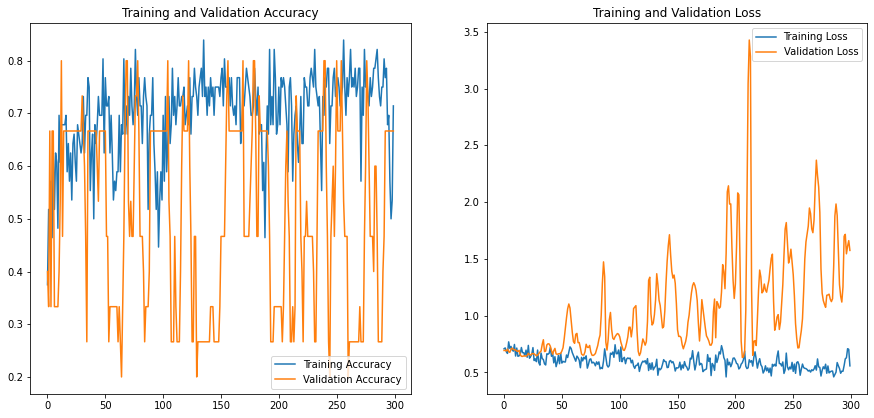

In [131]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(300)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The training loss indicates how well the model is fitting the training data, while the validation loss indicates how well the model fits new data.

Model is overfitting

# Image test

In [ ]:
image=Image.open('data/normal/1_left.jpg')

In [ ]:
width, height = image.size

In [ ]:
print(width,height)